In [3]:
import numpy as np
from pymanopt.manifolds import Sphere
import matplotlib.pyplot as plt
import mala.potentials
import mala.metropolis_hastings as mh
import mala.icosehedron as ico
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

%matplotlib notebook

%load_ext autoreload
%autoreload 2

phi = (1 + 5 ** 0.5) / 2

AttributeError: module 'mala' has no attribute 'icosehedron'

# A crash-course on how the icosahedron is currently implemented

Note: with the exception of the first figure, you should be able to rotate all of the figures in this notebook. If for some reason you can't, try re-running the first block, I have no idea why it doesn't take the first time sometimes.

Pre-emptively run tests to make sure all's working correctly:

In [2]:
from test_icosehedron import test_chart_maps

# tests generation of icosahedron face graph, transformations into/out
# of chart image
test_chart_maps()

# Generate vertices via G 

We have two generators, a permutation $(x,y,z)\rightarrow(z,x,y)$ and a negation $(x,y,z)\rightarrow(-x,y,z)$

$$G_1 = \begin{bmatrix}
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix},\qquad
G_2 = \begin{bmatrix}
-1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}$$

We can pick any arbitrary vertex of the icosehedron (e.g. $v_0 = (1,\phi,0)$) and its orbit under G will generate all the icosehedron vertices. We name the vertices by the group elements that generated them (this naming isn't unique: two elements of the group generate any $v_1$ from $v_0$, but we'll just stick to one of the two WOLG).

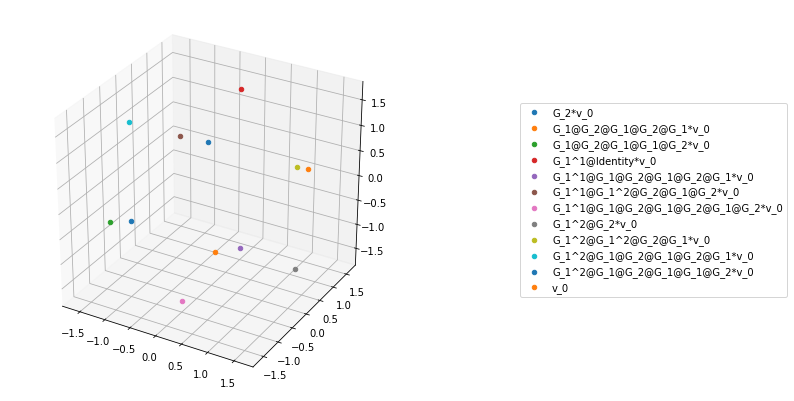

In [3]:
# To view the legend with the vertices' names, uncomment this line -------------------
%matplotlib inline
# To view the legend with the vertices' names, uncomment this line -------------------
# Note that you'll have to re-run the first section (%matplotlib notebook) to revert
# back to rotating figures

G = ico.generate_G(verbose=False)
V = ico.generate_V(G)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],label=v.name)
    
plt.legend(loc='right', bbox_to_anchor=(1, 0., 1, 1))
plt.show()

# Building face graph

Takes in a list of named vertices, assumed to correspond to the icosehedron. First builds a graph of labeled vertices, and then the dual graph, where each node corresponds to a face whose name is a tuple of vertex names

<IPython.core.display.Javascript object>


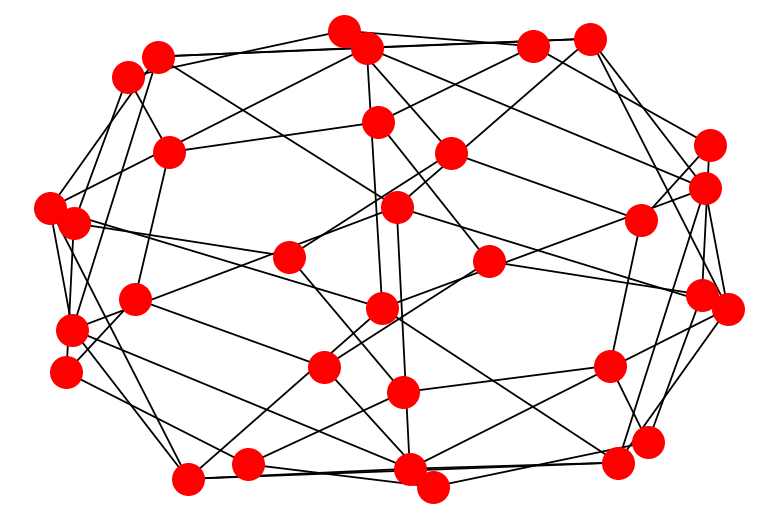

In [11]:
face_graph,vertex_graph = ico.build_face_graph(V,verify=True)
nx.draw(face_graph)
nx.draw(vertex_graph)

# face dict maps nodes in our face graph to ambient_face objects,
# which contain geometric information about the face
face_dict = ico.build_face_map(face_graph,V)

<IPython.core.display.Javascript object>


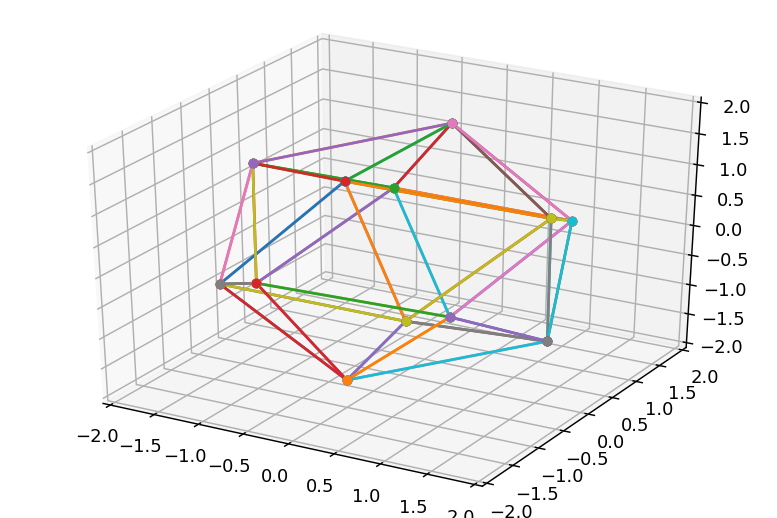

In [12]:
# Draw this monstrosity to make sure its doing what we want
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
for face_node in list(face_graph.nodes()):
    u,v,w = face_dict[face_node].list_vert_coors()
    for x,y in [[u,v],[v,w],[u,w]]:
        ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]])
    for v in face_dict[face_node].list_vert_coors():
        ax.scatter(v[0],v[1],v[2])
    
ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2) 
plt.show()

#look, a pretty icosehedron

# Transforming between chart coordinates and Euclidean coordinates

We need methods for projecting points on the sphere down into the $\mathbb{R}^2$ plane of the face and vice versa.

Our faces have a "handedness" defined by cross-prod of first and 2nd axis. When constructing our faces, wolg we ensure that all our faces will be "righthanded:" the cross-prod of first and 2nd spanning vector points out wrt the sphere.

This is fine for the icosahedron but in general we can't be guaranteed that our surface will be orientable. This really isn't a problem: in this case, if a face is left-handed, flip orientation to align first axis with positive x-axis. We only take the x- and y-coordinates as the image of our chart, so being flipped to top vs bottom of sphere doesn't matter. We have this implemented, but it should never have to be used.

<IPython.core.display.Javascript object>


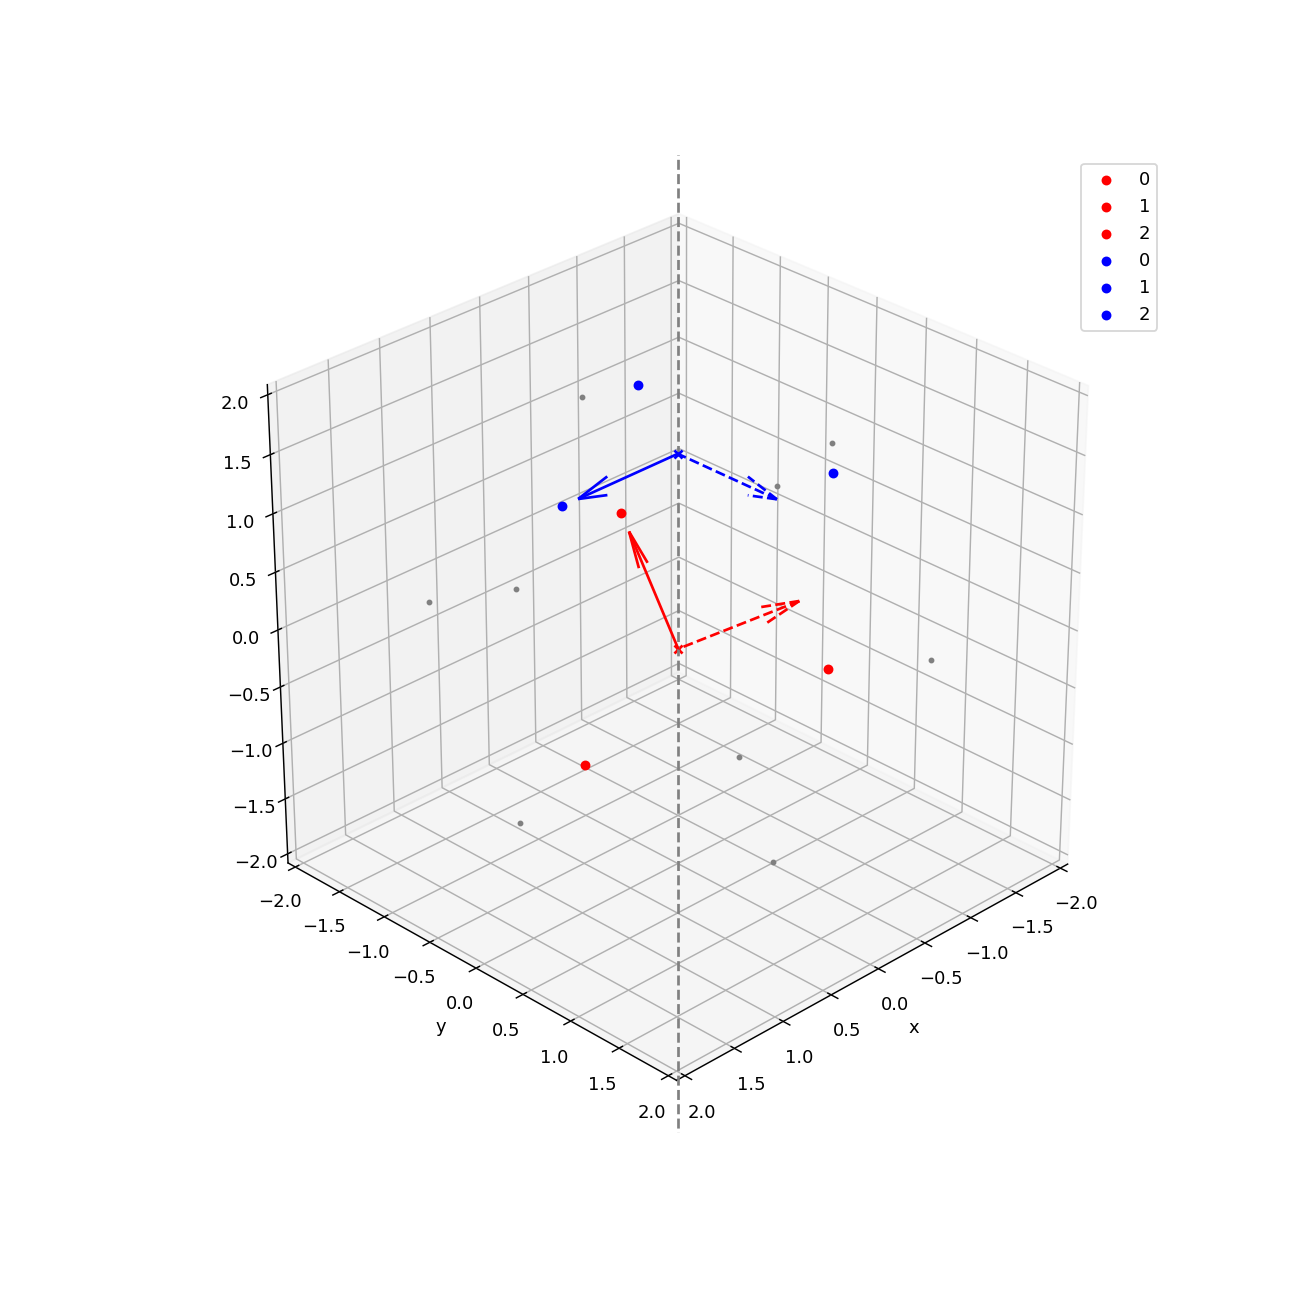

Is our target right-handed?  True


In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],marker='.',color='grey')

# some options for examining transformation of different faces

# all faces listed in our face graph/face map ARE right-handed
node_index = 11
target_face = face_dict[list(face_graph.nodes())[node_index]]

# if we pick arbitrary orderings of vectors for a face, some will be left-handed
#target_face = ico.ambient_face(V[6],V[7],V[1])
#target_face = ico.ambient_face(V[0],V[9],V[3])
#target_face = ico.ambient_face(V[6],V[2],V[10])

print('Is our target right-handed? ',ico.righthand_face(target_face))

# get the map that rotates our face centroid to z-axis and aligns face spanning vectors
# with x and y axis

# chart transformation
transformed_face = target_face.chart_transform_face()

color_list = ['r','blue']
for f_idx,face in enumerate([target_face,transformed_face]):
    for v_idx,p in enumerate(face.list_vert_coors()):
        ax.scatter(p[0],p[1],p[2],
                   color=color_list[f_idx],
                   label=str(v_idx))
        
    centroid = face.ctd_coors
    ax.scatter(centroid[0],centroid[1],centroid[2],marker='x',color=color_list[f_idx])
    style_list = ['-','--']
    for basis_idx,v_prime in enumerate([face.basis_1,face.basis_2]):
        ax.quiver(centroid[0],centroid[1],centroid[2],
             v_prime[0],v_prime[1],v_prime[2],linestyle=style_list[basis_idx],color = color_list[f_idx])

# draw z-axis
ax.plot([0,0],[0,0],[-5,5],'--',color='grey')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2) 

plt.legend()
plt.show()

## Right now, our charts have a radius 2x that of the faces' median

We want to be able to check whether the projection of a particular point (a) lies within the image of the chart of a face and/or (b) lies within the face $\textit{itself}$. **Note:** the first example, $(-2,-2,-2)$, gets labeled as "out of chart" even though its projection is so close to the face in $\mathbb{R}^2$ because it's pointing away from the face (i.e. dot product with vector from center of sphere to centroid is negative). If you remove that condition in check_if_point_in_chart, it would return true.

<IPython.core.display.Javascript object>


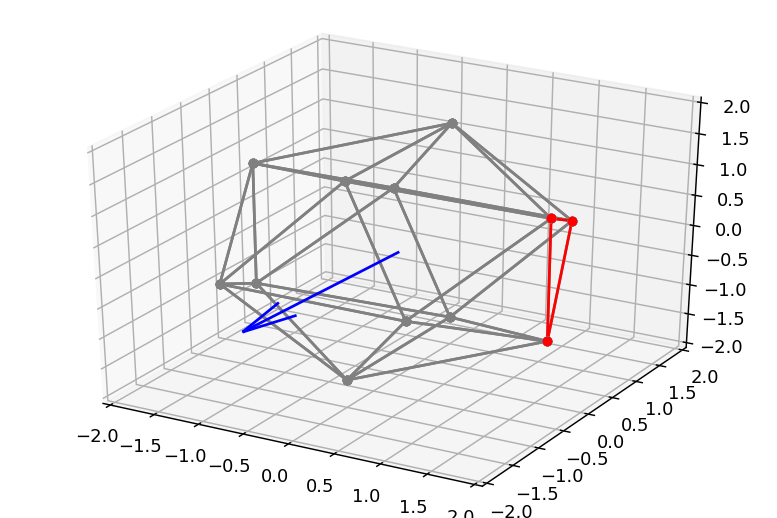

<IPython.core.display.Javascript object>


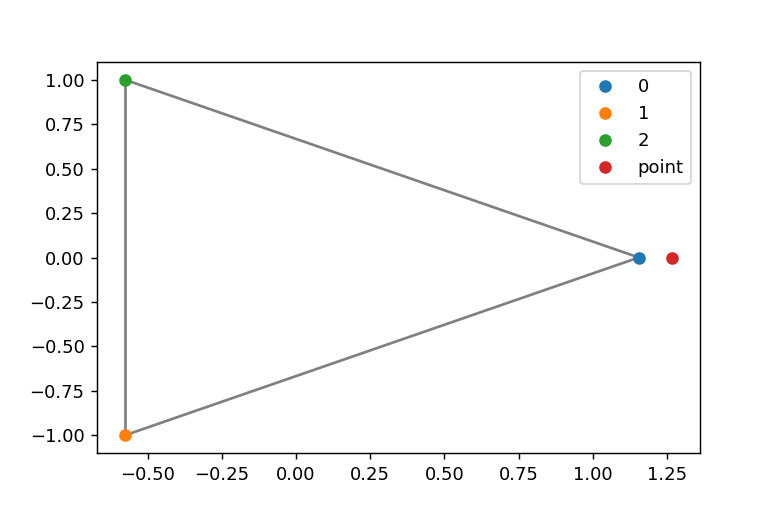

Is  [-1.09818547 -1.09818547 -1.09818547]  in this chart?  False
Is  [-1.09818547 -1.09818547 -1.09818547]  in this face?  False


<IPython.core.display.Javascript object>


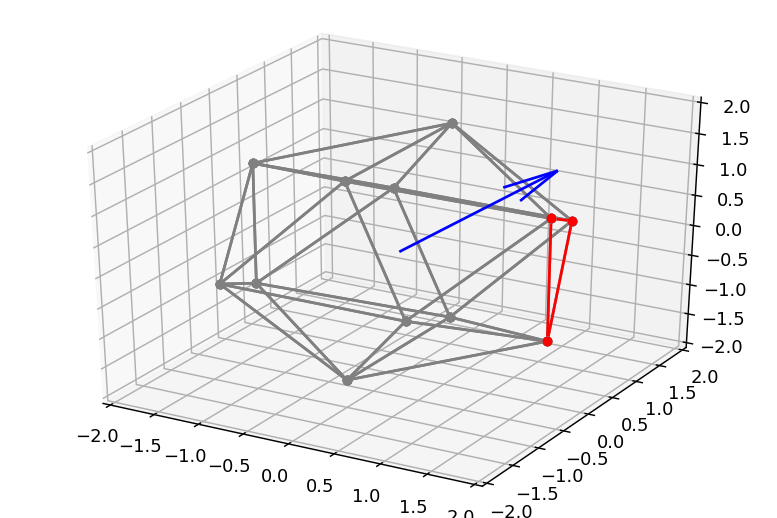

<IPython.core.display.Javascript object>


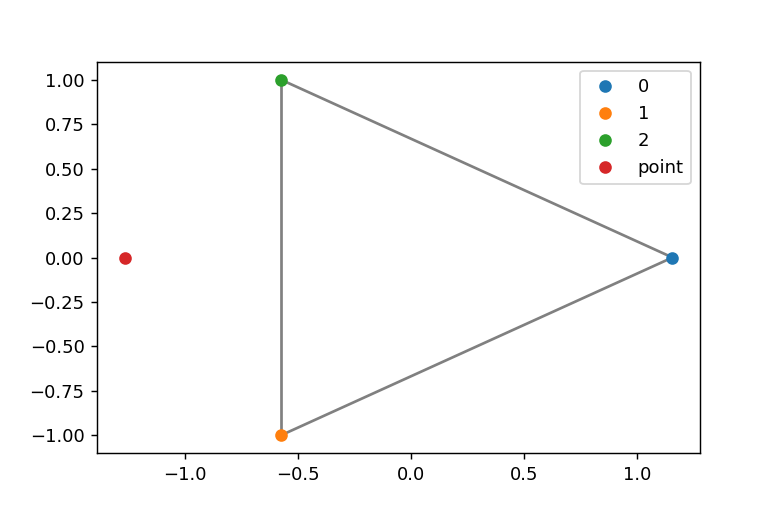

Is  [1.09818547 1.09818547 1.09818547]  in this chart?  True
Is  [1.09818547 1.09818547 1.09818547]  in this face?  False


<IPython.core.display.Javascript object>


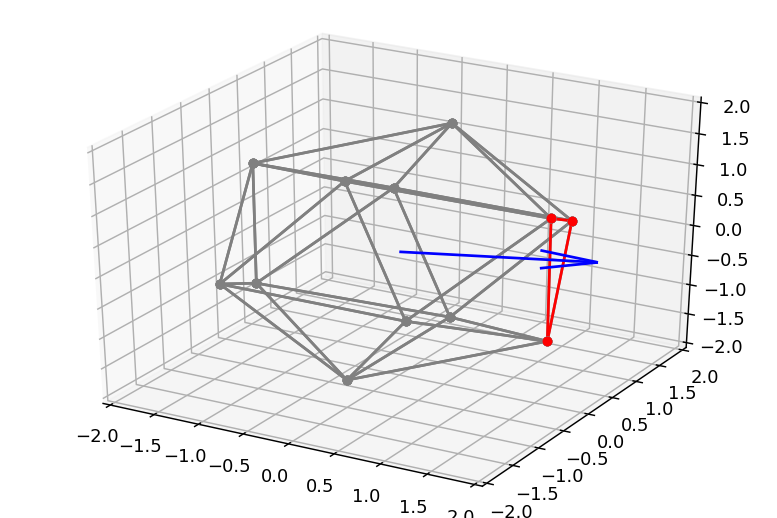

<IPython.core.display.Javascript object>


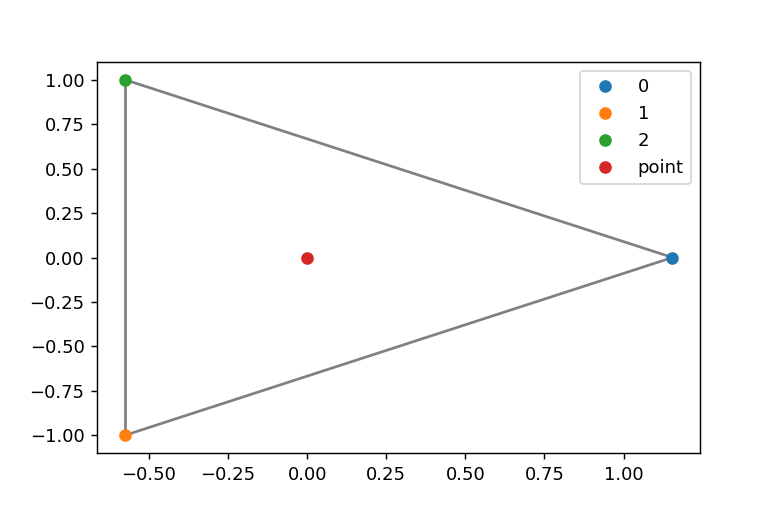

Is  [1.77690142 0.67871595 0.        ]  in this chart?  True
Is  [1.77690142 0.67871595 0.        ]  in this face?  True


In [16]:
target_idx = 19
target_face = face_dict[list(face_graph.nodes())[target_idx]]
point = -2*np.array([1,1,1])

sphere_radius = np.linalg.norm(target_face.v_1.p,ord=2)

for point in [-2*np.array([1,1,1]),np.array([1,1,1]),2*target_face.ctd_coors]:
    point = sphere_radius*np.divide(point,np.linalg.norm(point,ord=2))

    fig = plt.figure()
    ax = Axes3D(fig)
    for idx,face_node in enumerate(list(face_graph.nodes())):
        if idx==target_idx:
            plot_color = 'red'
        else:
            plot_color='grey'

        u,v,w = face_dict[face_node].list_vert_coors()
        for x,y in [[u,v],[v,w],[u,w]]:
            ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]],color=plot_color)
        for v in face_dict[face_node].list_vert_coors():
            ax.scatter(v[0],v[1],v[2],color=plot_color)

    ax.quiver(0,0,0,point[0],point[1],point[2],color='b')

    ax.axes.set_xlim3d(left=-2, right=2) 
    ax.axes.set_ylim3d(bottom=-2, top=2) 
    ax.axes.set_zlim3d(bottom=-2, top=2) 
    plt.show()
    
    # Now plot face and point in the image of the chart
    transformed_face = target_face.chart_transform_face()
    transformed_point = ico.euclidean2chart(point,target_face)
    
    plt.figure()
    # plot triangle sides
    u,v,w = transformed_face.list_vert_coors()
    for x,y in [[u,v],[v,w],[u,w]]:
        plt.plot([x[0],y[0]],[x[1],y[1]],color='grey')
    # scatter and label points
    for idx,x in enumerate([u,v,w]):
        plt.plot([x[0]],[x[1]],'o',label=idx)
    # scatter our point
    plt.plot([transformed_point[0]],[transformed_point[1]],'o',label='point')
    plt.legend()
    plt.show()
    

    print('Is ',point,' in this chart? ',ico.check_if_point_in_chart(point,target_face))
    print('Is ',point,' in this face? ',np.all(ico.check_if_point_in_face(point,target_face)))

# Methods not implemented above that we need to do Langevin sampling on the icosahedron

1. **face_across_edge( face, point_in_face_chart_coords, face_graph)** Given a point in R^2 which lies within the the chart corresponding to face but lies outside at least one of the lines l1,l2,l3, should return which face the point has now stepped in to. Right now in MA_metropolis_hastings I assume this returns a face_node (i.e. tuple of vertex names) but if it returned an ambient_face that'd be fine too.

2. **mat_pt_btwn_charts( point, origin_face, destination_face)** Given a point in the R^2 image of origin face, return the coordinates of that point in the R^2 image of the destination face.

I've got sample implementations of these below, but I got hungup on trying to chase down some problems caused by some inconsistencies in my choice of spanning vectors so I haven't tested them. Please feel free to test them or scrap them all together in favor of better ways to do the above.

### If we've stepped over the edge of a face, we want to know which face we've stepped into.

In [22]:
from itertools import compress

# pt is a numpy array of coordinates in the image of our origin face chart.
# given a point accross the edge of our face, ID which face it
# has crossed into and change its coordinates
def transition_charts(pt,origin_face,face_graph):
    # make sure we're in our chart, and have crossed an edge
    assert check_if_point_in_chart(pt,origin_face)
    assert check_if_point_in_chart(pt,origin_face)
    
    # determine which edge we've crossed
    side_crossings = [not inside_l for inside_l in check_if_point_in_face(pt,face)]
    
    # determine which face we're stepping into
    destination_face = face_across_edge(origin_face,side_crossings,face_graph)
    
    # change coordinates
    return map_pt_btwn_charts(pt,origin_face,dest_face)

# side_crossings is a list of booleans indicating whether we're crossing
# over l1, l2, or l3 (recall these correspond to the lines between 
# [ (x2,x3),(x1,x3),or (x1,x2)] respectively), as per conventions
# in "Isabelle's Icosahedron"
def face_across_edge(face,side_crossings,face_graph):
    # first, ID the edge we're traversing using a pair of vertices
    face_verts = (face.v_1.name,face.v_2.name,face.v_3.name)
    vertex_pairs = [(face_verts[1],face_verts[2]),(face_verts[0],face_verts[2]),
                    (face_verts[0],face_verts[1])]
    edge = list(compress(vertex_pairs,side_crossings))[0]
    
    # find a face that contains the same edge that isn't our og face
    edge_adjacent_face = [f for f in face_graph if len(set(edge) & set(f))==2 
                       and set(f)!=set(face_verts)]
    
    return edge_adjacent_face

# pt is a numpy array of coordinates in the image of our origin face chart.
def map_pt_btwn_charts(pt,origin_face,dest_face):
    # pt needs to be in the overlap of the face charts
    assert check_if_point_in_chart(pt,origin_face)
    assert check_if_point_in_chart(pt,dest_face)
    
    # first, get Euclidean coordinates of our point
    euc_pt = chart2euclidean(pt,origin_face)
    
    # next, move into coordinates of second chart
    return euclidean2chart(euc_pt,dest_face)
    